In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from collections import Counter

import os
from PIL import Image
import glob
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.models as models

In [3]:
dataset = datasets.ImageFolder(r".\trees\train")

In [4]:
def visualise(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    for i, (image, _) in enumerate(items):
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.show()

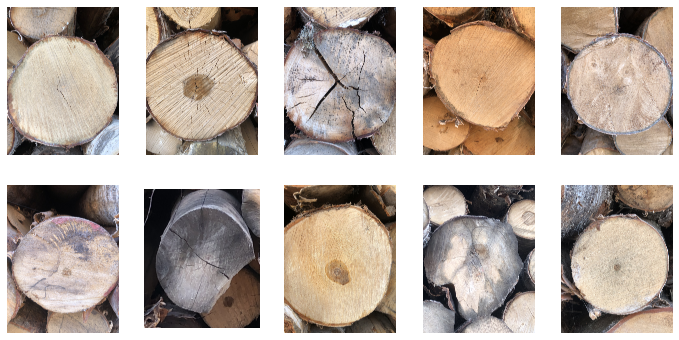

In [5]:
length = len(dataset)
indexes = np.random.choice(list(range(length)), size=10, replace=False)

visualise(dataset, indexes)

In [6]:
#Функция для обрезки изображения по центру
def crop_center(pil_img, crop_width: int, crop_height: int) -> Image:
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [7]:
i = 0
for file in dataset:
    image, label = file
    width, height = image.size
    base_width, base_height = 224, 224
    super_width, super_height = 264, 264
    
    if (width > height):
        image = image.resize((super_width, base_height), Image.ANTIALIAS)
    elif (width < height):
        image = image.resize((base_width, super_height), Image.ANTIALIAS)
    else:
        image = image.resize((base_width, base_height), Image.ANTIALIAS)
    
    image = crop_center(image, 224, 224)
    file_name = str(i) + ".png"
    
    if (label == 0):
        image.save(r".\trees_224\train\1" +'\\'+ file_name)
    elif (label == 1):
        image.save(r".\trees_224\train\3" +'\\'+ file_name)
    else:
        image.save(r".\trees_224\train\drova" +'\\'+ file_name)
    i += 1

In [8]:
EPOCHS = 20
BATCH_SIZE = 32

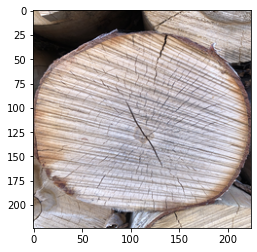

In [9]:
train_dataset = datasets.ImageFolder(r".\trees_224\train", transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
plt.imshow(train_dataset[255][0].numpy().transpose([1, 2, 0]), vmin=0, vmax=255)

In [10]:
class_weights = dict(Counter(train_dataset.targets))
class_weights

{0: 299, 1: 208, 2: 68}

In [11]:
class_weights = [299, 208, 68]

In [12]:
class_weights = 1. / torch.tensor(class_weights, dtype=torch.float) 
class_weights

tensor([0.0033, 0.0048, 0.0147])

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [285]:
#данная модель показала себя лучше, чем семейство efficient и resnet
model = models.densenet161(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [286]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(in_features=2208, out_features=3, bias=True)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss(class_weights.to(device)) #используем взвешенную кроссэнтропию из-за дисбаланса классов
loss_history = list()  # список для хранения истории изменения функции стоимости

In [288]:
# Начинаем обучение
model.train()
for epoch in range(EPOCHS):
    
    acc = 0
    f1 = 0
    
    for i, (batch, labels) in enumerate(tqdm(train_loader)):
        loss = torch.tensor(0, dtype=torch.float32)
        optimizer.zero_grad()
        batch = batch.to(device)
        labels = labels.to(device)
        output = model(batch)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        
        # ===============
        outputs = torch.argmax(output, dim=1)
        f1 += f1_score(labels.cpu(), outputs.cpu(), average='macro')
        acc += accuracy_score(labels.cpu(), outputs.cpu())
        
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
        
    train_f1 = f1 / len(train_loader)
    final_acc = acc / len(train_loader)
    
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')
    print(f'F1: {train_f1} Acc: {final_acc}')

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.43it/s]


Эпоха 1 завершилась с функцией стоимости на последнем пакете = 0.6966419816017151
F1: 0.5080803377370632 Acc: 0.586581541218638


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s]


Эпоха 2 завершилась с функцией стоимости на последнем пакете = 0.5629022717475891
F1: 0.8847894477146812 Acc: 0.8973454301075269


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.37it/s]


Эпоха 3 завершилась с функцией стоимости на последнем пакете = 0.656161904335022
F1: 0.8751511569238253 Acc: 0.9073140681003584


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.32it/s]


Эпоха 4 завершилась с функцией стоимости на последнем пакете = 0.2945402264595032
F1: 0.8764026403071702 Acc: 0.8974014336917562


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s]


Эпоха 5 завершилась с функцией стоимости на последнем пакете = 0.31057974696159363
F1: 0.8976072485996259 Acc: 0.9164986559139785


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s]


Эпоха 6 завершилась с функцией стоимости на последнем пакете = 0.18458192050457
F1: 0.9295753277551894 Acc: 0.9461245519713262


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]


Эпоха 7 завершилась с функцией стоимости на последнем пакете = 0.22699959576129913
F1: 0.9456918551011435 Acc: 0.9600694444444444


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.43it/s]


Эпоха 8 завершилась с функцией стоимости на последнем пакете = 0.2360941469669342
F1: 0.9383300283237195 Acc: 0.9565412186379929


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]


Эпоха 9 завершилась с функцией стоимости на последнем пакете = 0.1260155439376831
F1: 0.9404960767254392 Acc: 0.958277329749104


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s]


Эпоха 10 завершилась с функцией стоимости на последнем пакете = 0.09104698151350021
F1: 0.9699581839145502 Acc: 0.9722222222222222


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.40it/s]


Эпоха 11 завершилась с функцией стоимости на последнем пакете = 0.4407404363155365
F1: 0.9505067475986176 Acc: 0.9632056451612903


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s]


Эпоха 12 завершилась с функцией стоимости на последнем пакете = 0.15552730858325958
F1: 0.9567038126749592 Acc: 0.9791106630824373


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]


Эпоха 13 завершилась с функцией стоимости на последнем пакете = 0.10169529914855957
F1: 0.9691142095115904 Acc: 0.9774305555555556


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.36it/s]


Эпоха 14 завершилась с функцией стоимости на последнем пакете = 0.11070415377616882
F1: 0.9486743377544813 Acc: 0.973902329749104


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.36it/s]


Эпоха 15 завершилась с функцией стоимости на последнем пакете = 0.07855299860239029
F1: 0.9847714046627374 Acc: 0.9843189964157707


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.36it/s]


Эпоха 16 завершилась с функцией стоимости на последнем пакете = 0.10804233700037003
F1: 0.9671620375815182 Acc: 0.9773745519713262


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.35it/s]


Эпоха 17 завершилась с функцией стоимости на последнем пакете = 0.09586592763662338
F1: 0.9547170297771232 Acc: 0.96875


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.36it/s]


Эпоха 18 завершилась с функцией стоимости на последнем пакете = 0.09463240206241608
F1: 0.9744812253311541 Acc: 0.9843189964157707


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]


Эпоха 19 завершилась с функцией стоимости на последнем пакете = 0.05884118005633354
F1: 0.9709486347367814 Acc: 0.9809027777777778


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.40it/s]

Эпоха 20 завершилась с функцией стоимости на последнем пакете = 0.09822458773851395
F1: 0.9891831506144138 Acc: 0.9929995519713262


In [290]:
model.eval()

f1_train = 0
acc_train = 0
    
for i, (batch, labels) in enumerate(train_loader):

    batch = batch.to(device)
    labels = labels.to(device)
    output = model(batch)    
            
    outputs = torch.argmax(output, dim=1)
    f1_train += f1_score(labels.cpu(), outputs.cpu(), average='macro')
    acc_train += accuracy_score(labels.cpu(), outputs.cpu())
            

print(f1_train / len(train_loader))
print(acc_train / len(train_loader))

0.9895356273398151
0.9947916666666666


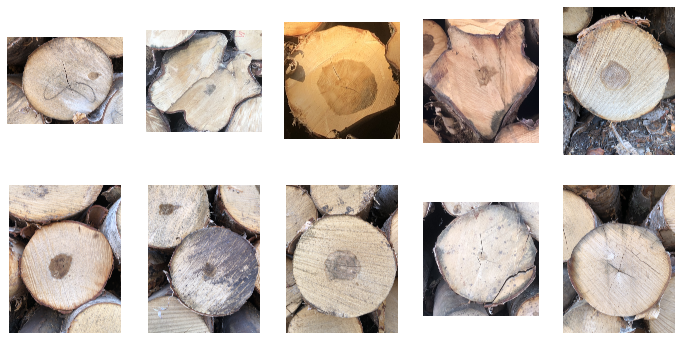

In [297]:
test_dataset = datasets.ImageFolder(r".\trees\test")

length = len(test_dataset)
indexes = np.random.choice(list(range(length)), size=10, replace=False)

visualise(test_dataset, indexes)

In [298]:
images = []
for i in range(len(test_dataset)):
    image = test_dataset[i][0]
    width, height = image.size
    base_width, base_height = 224, 224
    super_width, super_height = 264, 264
    
    if (width > height):
        image = image.resize((super_width, base_height), Image.ANTIALIAS)
    elif (width < height):
        image = image.resize((base_width, super_height), Image.ANTIALIAS)
    else:
        image = image.resize((base_width, base_height), Image.ANTIALIAS)
    
    image = crop_center(image, 224, 224)
    images.append(image)

In [162]:
class PredDataset(Dataset):
    
    def __init__(self, images, transform=transforms.ToTensor()):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        input_img = self.images[idx] 
        
        if self.transform:
            img = self.transform(input_img)
        
        return img

In [299]:
pred_dataset = PredDataset(images)

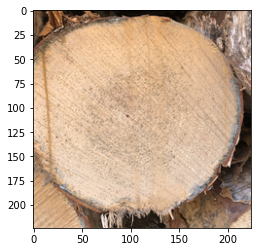

In [300]:
plt.imshow(pred_dataset[6].numpy().transpose([1, 2, 0]), vmin=0, vmax=255)

In [301]:
# Отключаем расчет вычислительного графа для экономии времени и памяти, т.к. нам не нужно считать градиенты при тестировании модели
test_model_predictions = []
size = len(pred_dataset)
with torch.no_grad():
    # Оцениваем качество модели
    test_data_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=1, shuffle=False)
    for i, test_features in enumerate(test_data_loader):
        test_features = test_features.to(device)
        _, predict = torch.max(model(test_features), 1)
        test_model_predictions.append(int(predict))

In [302]:
len(test_model_predictions)

249

In [303]:
files = []
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
for file in data_loader.dataset.samples:
    file = str(file)
    files.append(int(file[file.rfind('\\')+1:file.rfind('.')]))

In [304]:
#Метки классов записаны не в соответствии с требуемым форматом
test = []
for i in test_model_predictions:
    if i == 0:
        test.append(1)
    if i == 1:
        test.append(3)
    if i == 2:
        test.append(0)

In [305]:
sample_sub = pd.DataFrame({'id': files, 'class': test})
sort_sample_sub = sample_sub.sort_values(by=['id'])
sort_sample_sub

,id,class
0,1,1
111,2,3
172,3,0
183,4,3
194,5,1
...,...,...
162,245,1
163,246,1
164,247,1
165,248,1


In [306]:
sort_sample_sub.to_csv("submissions.csv", index=False)